## 介绍
本次竞赛的目的是使用历史贷款申请数据来预测申请人是否能够偿还贷款。 这是一个标准的监督分类任务。

## 数据
这些数据由Home Credit提供，Home Credit是一项致力于为未开设银行账户的人口提供信贷额度（贷款）的服务。

有7种不同的数据来源：
* application_train/application_test: 主要的训练和测试数据，每一行为一条贷款申请记录
* bureau: 有关客户来自其他金融机构的信贷数据
* bureau_balance: 来自其他金融机构的月度信用/信贷数据
* previous_application: 申请表中的客户以前在 Home Credit 申请信贷的数据记录
* pos_cash_balance: 申请表中的客户以前在 Home Credit 的销售点或现金贷款月度数据
* credit_card_balance: 客户以前在 Home Credit 的信用卡月度数据
* installments_payment: 以前在Home Credit的贷款的付款历史
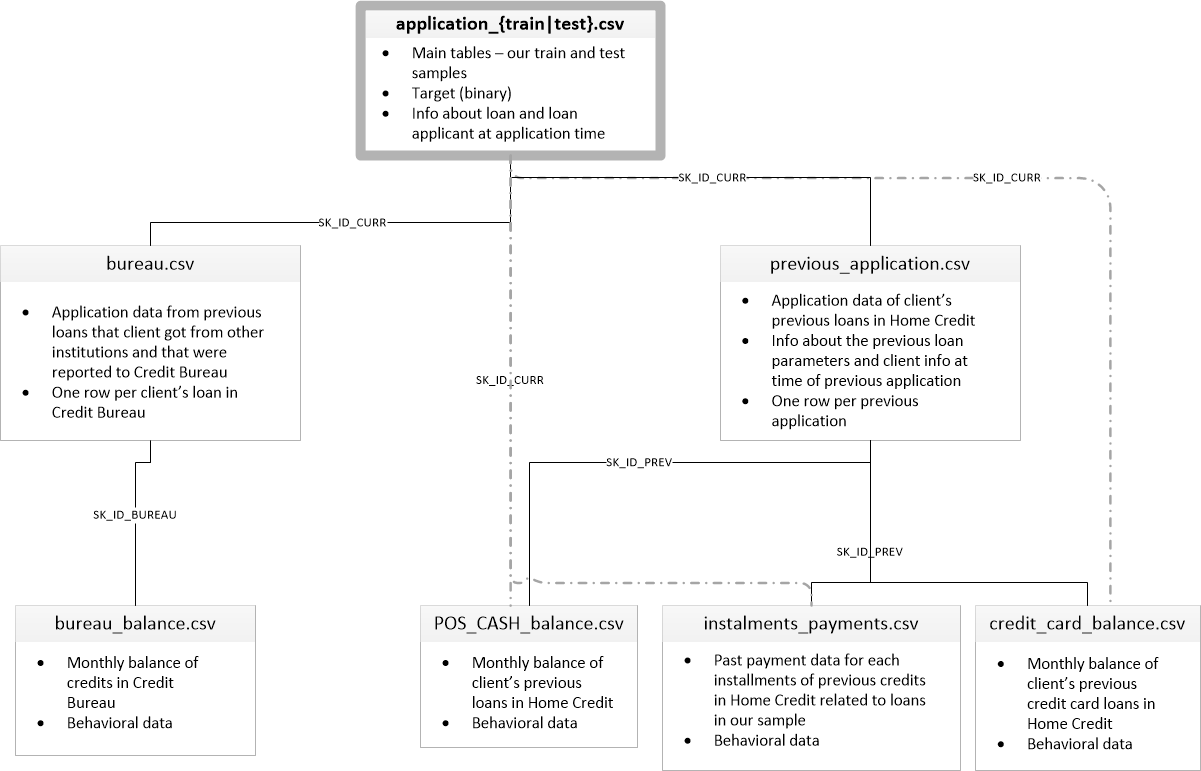

## Part1 只使用主表

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 读数据

In [ ]:
print(os.listdir("../input/"))

In [ ]:
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

**上表中部分内容解释**
* Target=0表示偿还了贷款，target=1表示未偿还
* Revolving loans: 周转性贷款   realty: 房地产，不动产 
* 其他字段：https://blog.csdn.net/u014281392/article/details/81121122?utm_source=blogxgwz0**

In [ ]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

## 探索性数据分析
探索性数据分析数据分析是一个开放性过程，我们计算数据的统计信息，绘制图表，以发现数据中的趋势，异常，模式和关系。

### 查看target列的分布情况

In [ ]:
app_train['TARGET'].value_counts()

In [ ]:
app_train['TARGET'].astype(int).plot.hist()

从这些信息中，我们看到这是一个不平衡的分类问题。按时偿还的贷款远远多于未偿还的贷款。一旦我们使用更复杂的机器学习模型，我们可以通过它们在数据中的表示来对类进行加权以反映这种不平衡。

### 查看缺失值

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        by='% of Total Values', ascending=False).round(1)   # iloc[:,1]取第二列， round(1)保留一位小数
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values = missing_values_table(app_train)
missing_values.head(10)

当构建我们的机器学习模型时，我们将不得不填写这些缺失值（称为填充）。有些模型可以处理缺失值，不需要填充，如XGBoost。另一个选择是删除具有高百分比缺失值的列，但我们无法知道这些列对我们的模型是否有帮助。因此，我们暂时保留所有列。

### 列类型
object为string和其他 categorical features

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

查看每一个object类型的列有多少种取值

In [ ]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

OCCUPATION_TYPE: 职业类型  ORGANIZATION_TYPE: 客户工作的组织类型

**axis**
* 使用0值表示沿着每一列或行标签/索引值向下执行方法
* 使用1值表示沿着每一行或者列标签横向执行对应的方法
* 简单的来记就是axis=0代表往跨行，而axis=1代表跨列

### 编码类别变量
在我们进一步讨论之前，我们需要处理类别变量。 机器学习模型无法处理类别变量（除了少数模型，如LightGBM）。 因此，我们必须找到一种方法，将这些变量编码（表示）为数字。 执行此过程有两种主要方式：
* Label encoding: 为类别变量的每一类赋值一个整数。
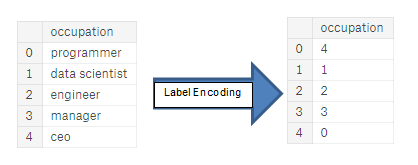

* One-hot encoding: 为类别变量的每一类创建一个新的列，如图：
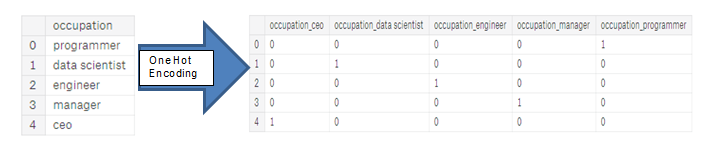

label encoding的问题在于它为类别提供了顺序。分配给每个类别的值是随机的，并不反映该类别的任何内在含义。当我们执行标签编码时，模型可能会使用特征的相对值（例如programmer=4和data scientist=1）来分配权重，这不是我们所希望的。如果类别变量只有两种取值，如性别，那么可以使用label encoding，但对于取值超过2个的类别，one-hot编码是安全选项。

#### Label Encoding and One-Hot Encoding
只有两个取值的类别变量进行label encoding，对超过两个取值的类别进行one-hot编码

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            print(col)
            
print('%d columns were label encoded.' % le_count)

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

#### 对齐训练和测试数据

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
# https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

由于one-hot编码，特征数量多了很多

### 回到数据分析

#### 异常

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

年龄字段中是天数，且为负值，表示在之前多少天出生。这些年龄看起来很合理，无论是最大值最小值，都没有年龄异常值。 看看就业天数怎么样？

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print(anom.shape)
print(non_anom.shape)
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

有趣的是，就业天数异常的违约率较低。

处理异常取决于具体情况，没有既定规则。 最安全的方法之一就是将异常设置为缺失值，然后在进行模型训练之前对它们填充。在这种情况下，由于所有异常都具有完全相同的值，我们希望用相同的值填充它们，以防这些贷款具有一些共同点。异常值似乎有一些重要性，所以我们想告诉机器学习模型我们是否填充了这些值。一个解决方案是，将异常值填充为Nan，然后创建一个新的布尔列，指示该值是否异常。


In [ ]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')


分布现在看起来符合我们的预期，我们还创建了一个新列，告诉模型这些值最初是异常的（因为我们必须用一些值填充nans，可能是特征的中位数）。数据表中带有DAYS的其他列没有明显的异常值。

In [ ]:
# 对测试数据进行同样的处理
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

#### 相关性

尝试理解数据的一种方法是计算特征和目标（target）之间的相关性。我们可以使用Pearson相关性系数。相关系数不是表示特征“相关性”的最佳方法，但它确实可以让我们了解数据中可能存在关系。[对相关系数绝对值的一般解释是](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf)：
* 0.00-0.19 “very weak”
* 0.20-0.39 “weak”
* 0.40-0.59 “moderate”
* 0.60-0.79 “strong”
* 0.80-1.0  “very strong”

In [ ]:

# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Negative Correlations:\n', correlations.head(10))
print('\nMost Positive Correlations:\n', correlations.tail(10))

可以看出DAY_BIRTH和target的相关性最强。且相关系数为正，即随着DAY_BIRTH的减小，target也减小。注意DAY_BIRTH为负数，越小表示年龄越大。这意味着年龄越大的客户，正常还款的可能性越大。target=0表示正常还款。

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

就上图而言，除了告诉我们年龄没有异常值之外，没有什么别的信息。为了可视化目标对年龄的影响，我们将根据目标值绘制年龄的[核密度估计](https://lotabout.me/2018/kernel-density-estimation/)图。核密度估计图显示单个变量的分布，可以认为是平滑的直方图。

In [ ]:
plt.figure(figsize = (10, 8))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

从上图可以看出正常偿还贷款的人和拖欠贷款的人的年龄分布有差别，年龄可能是一个对模型有用的特征。

再按年龄段查看一下拖欠贷款的情况。

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

target的均值表示该年龄段拖欠贷款的比例

In [ ]:
plt.figure(figsize = (6, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

#### 外部资源

与target呈最大负相关性的3个变量为EXT_SOURCE_1，EXT_SOURCE_2，EXT_SOURCE_3。根据文档，这些功能代表“来自外部数据源的标准化分数”。 我不确定这究竟是什么，但它可能是使用大量数据来源累积的信用评级。

首先，我们来看看EXT_SOURCE变量和target以及彼此之间的相关性。

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (6, 5))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

所有三个EXT_SOURCE特征都与目标具有负相关性，表明随着EXT_SOURCE值的增加，客户更有可能偿还贷款。 我们还可以看到DAYS_BIRTH与EXT_SOURCE_1正相关，表明该分数中的一个因素可能是客户年龄。

接下来，我们可以查看由目标值着色的每个特征的分布。 这将让我们可视化此变量对目标的影响。

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3在不同target上，分布的差异较大，此特征与申请人偿还贷款的可能性有一定关系。这种关系不是很强（实际上它们被认为非常弱，pearson系数只有-0.18），但这些变量对于机器学习模型仍然有用。

## 特征工程
特征工程包括特征构造：从现有数据中构造新特征，以及特征选择：仅选择最重要的特征或其他降维方法。 我们可以使用许多技术来创建特征和选择特征。

当我们开始使用其他数据源时，我们会做很多特征工程，但在这个笔记本中我们只会尝试两种简单的特征构建方法：
* Polynomial features(多项式特征）
* Domain knowledge features（领域知识特征）

### Polynomial Features

一种简单的特征构造方法称为多项式特征。在此方法中，我们创建的特征是现有特征的乘积。例如，我们可以创建变量 EXT_SOURCE_1^2, EXT_SOURCE_1 x EXT_SOURCE_2，等。这些由多个单独变量组合而来的特征称为交互项，因为它们捕获变量之间的交互。换句话说，虽然两个变量本身可能不会对目标产生强烈影响，但将它们组合在一起形成一个交互变量可能会显示与目标的关系。交互项通常用于统计模型中以捕获多个变量的影响，但我不认为它们在机器学习中经常使用。尽管如此，我们可以尝试一些，看看他们是否可以帮助我们的模型来预测客户是否会偿还贷款。

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

In [ ]:
poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                     columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                   'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
# https://www.cjavapy.com/article/291/
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

### Domain Knowledge Features

Here I'm going to use following features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:
* CREDIT_INCOME_PERCENT：贷款总额占客户收入的百分比
* ANNUITY_INCOME_PERCENT：贷款年金占客户收入的百分比
* CREDIT_TERM：付款期限，月为单位，因为年金需要按月交
* DAYS_EMPLOYED_PERCENT：就业天数相对于客户年龄的百分比

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### 可视化新的变量

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

我们很难提前知道这些新的特征是否有用，唯一的方法是放到模型中试一下。

## Baseline

### 逻辑回归
要获得基线，我们只使用对类别变量进行编码后的特征。我们将通过填充缺失值和标准化特征来对数据进行预处理。

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)    # C:正则化强度的倒数

# Train on the training data
log_reg.fit(train, train_labels)

In [ ]:
# Make predictions
# Make sure to select the second column only
# result中第一列为预测0的概率，第二列为预测为1的概率
result = log_reg.predict_proba(test)
log_reg_pred = result[:, 1]
result[0]

In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
submit.head()

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

The logistic regression baseline should score around **0.671** when submitted.

### 随机森林
随机森林是一个更强大的模型，特别是当我们使用数百棵树时。 我们将在随机森林中使用100棵树。

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifiern
# verbos：是否显示任务进程   n-jobs: 1=不并行；n：n个并行；-1：CPU有多少core，就启动多少job。
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

This model should score around **0.678** when submitted.

#### Make Predictions using Engineered Features
**测试多项式特征**

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

该模型在提交给竞赛时得分为**0.678**，与没有工程特征的模型完全相同。在这种情况下我们的特征构造似乎没有帮助。

**测试领域特征**

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

提交时得分为0.679，这可能表明工程特征对此模型没有帮助（但它们在后面会介绍的Gradient Boosting Model中有帮助）。

### 模型解释：特征的重要性

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh((list(reversed(list(df.index[:15])))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    #ax.set_yticks(list(df.index[:15]))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

正如所料，最重要的功能是处理EXT_SOURCE和DAYS_BIRTH的功能。 我们发现只有少数特征对模型具有重要意义，这表明我们可以在不降低性能的情况下丢弃许多特征（我们甚至可以看到性能的提高）。特征重要性不是解释模型或执行降维的最复杂方法，但它们让我们开始了解模型在进行预测时会考虑哪些因素。

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

可以看到所有四个手工设计的特征都在最重要的前15名！这应该让我们相信我们的领域知识在一定程度上步入了正轨。